In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(context='notebook', font='Fira Sans', style='white', palette='plasma')

In [2]:
import pandas as pd
import geopandas as gpd

In [3]:
import dask.dataframe as dd

In [4]:
areas = gpd.read_file('output/relevant_area.geo.json')

In [5]:
grid = gpd.read_file('output/relevant_grid.geo.json')

In [7]:
bbox = areas.total_bounds
bbox

array([ 1.8467312, 41.263409 ,  2.2964971, 41.5749847])

In [8]:
pois = dd.read_csv('4sq_2019/raw_POIs.txt', sep='\t', names=['venue_id', 'lat', 'lon', 'category', 'country'])

In [9]:
pois.head()

,venue_id,lat,lon,category,country
0,3fd66200f964a52000e61ee3,40.729209,-73.998753,Post Office,US
1,3fd66200f964a52000e71ee3,40.733596,-74.003139,Jazz Club,US
2,3fd66200f964a52000e81ee3,40.758102,-73.975734,Gym,US
3,3fd66200f964a52000ea1ee3,40.732456,-74.003755,Indian Restaurant,US
4,3fd66200f964a52000ec1ee3,42.345907,-71.087001,Indian Restaurant,US


In [10]:
pois_in_bbox = pois[pois.lon.between(bbox[0], bbox[2]) & pois.lat.between(bbox[1], bbox[3])].compute()
pois_in_bbox.sample(5)

,venue_id,lat,lon,category,country
413216,4de2883652b1d38d297050dd,41.464962,2.239910,Shop & Service,ES
137799,4bf91cdbb182c9b69e6c785a,41.391785,2.152947,Mediterranean Restaurant,ES
98981,5093d11ee4b0a7ac702b1427,41.323620,2.100910,Restaurant,ES
82955,5091bd34e4b054e683607d70,41.378202,2.153286,Assisted Living,ES
112702,4cc3508cbde8f04d3c72a44b,41.547697,2.107241,Italian Restaurant,ES


In [11]:
len(pois_in_bbox)

25339

Text(0.5, 0, '# of Venues (POIs)')

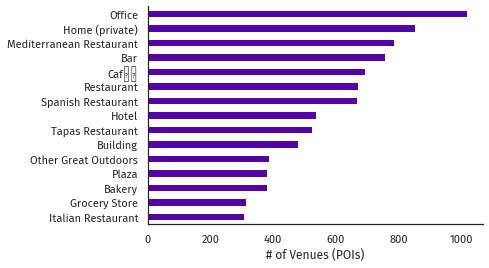

In [60]:
ax = pois_in_bbox.category.value_counts().head(15).sort_values().plot(kind='barh')
sns.despine(ax=ax)
ax.set_xlabel('# of Venues (POIs)')

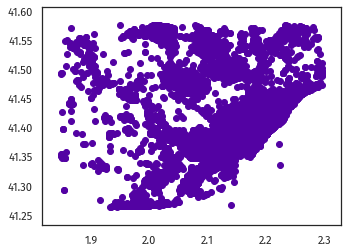

In [15]:
pois_gdf = gpd.GeoDataFrame(pois_in_bbox[['venue_id', 'category']],
                            geometry=gpd.points_from_xy(pois_in_bbox.lon, pois_in_bbox.lat),
                            crs=areas.crs)
pois_gdf.plot()

In [65]:
pois_gdf_amb = gpd.sjoin(pois_gdf, grid[['geometry',]], op='within', how='inner')
pois_gdf_amb

,venue_id,category,geometry,index_right
69289,4ad0e340f964a520c7da20e3,Southern / Soul Food Restaurant,POINT (2.15161 41.39223),2192
83087,4adcda4bf964a520873f21e3,Hotel,POINT (2.15006 41.39436),2192
83093,4adcda4cf964a520903f21e3,Hotel,POINT (2.15351 41.39404),2192
83145,4adcda4df964a520084021e3,Cocktail Bar,POINT (2.15427 41.39277),2192
83155,4adcda4df964a520164021e3,Beer Garden,POINT (2.15316 41.39503),2192
...,...,...,...,...
265030,523816c411d2e48e8a26b0aa,Factory,POINT (1.98903 41.46473),1391
285290,524012d811d22f52076ace02,Plane,POINT (2.08621 41.29014),2882
385948,527601a211d21ebf3efe796a,Tennis Court,POINT (1.99406 41.28381),477
500424,52cfeafc498e897f5c116008,Home (private),POINT (1.95391 41.41971),1069


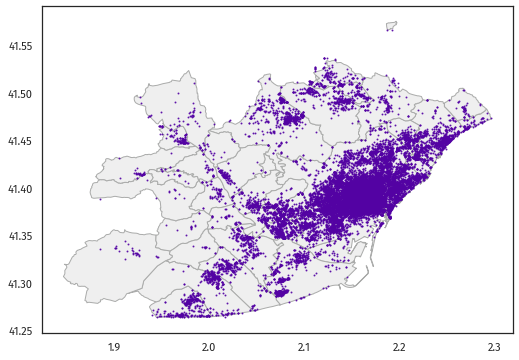

In [66]:
ax = areas.plot(figsize=(16, 6), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
pois_gdf_amb.plot(ax=ax, markersize=1, alpha=0.8)

In [67]:
pois_grid = gpd.sjoin(pois_gdf, grid[['geometry',]], op='within', how='inner')


In [68]:
pois_grid.head()

,venue_id,category,geometry,index_right
69289,4ad0e340f964a520c7da20e3,Southern / Soul Food Restaurant,POINT (2.15161 41.39223),2192
83087,4adcda4bf964a520873f21e3,Hotel,POINT (2.15006 41.39436),2192
83093,4adcda4cf964a520903f21e3,Hotel,POINT (2.15351 41.39404),2192
83145,4adcda4df964a520084021e3,Cocktail Bar,POINT (2.15427 41.39277),2192
83155,4adcda4df964a520164021e3,Beer Garden,POINT (2.15316 41.39503),2192


In [24]:
grid_n_pois = pois_grid.groupby('index_right').size()
grid_n_pois.name = 'poi_count'

Text(0.5, 1, '# of POIs in the Barcelona Metropolitan Area (Foursquare data)')

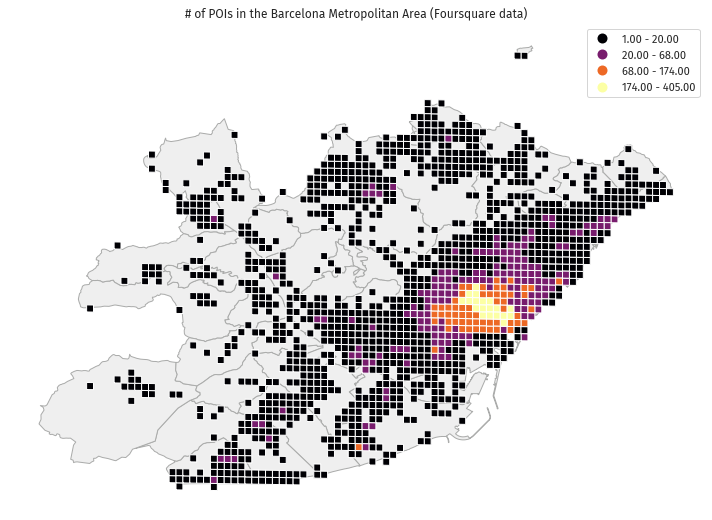

In [69]:
ax = areas.plot(figsize=(18, 9), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
grid.join(grid_n_pois).dropna().plot(column='poi_count', cmap='inferno', k=4, scheme='Fisher_Jenks', ax=ax, legend=True)
ax.set_axis_off()
ax.set_title('# of POIs in the Barcelona Metropolitan Area (Foursquare data)')

In [39]:
check_ins = dd.read_csv('4sq_2019/raw_Checkins_anonymized.txt', sep='\t', names=['user_id', 'venue_id', 'datetime', 'utc_offset'])
check_ins.head()

,user_id,venue_id,datetime,utc_offset
0,546830,4f5e3a72e4b053fd6a4313f6,Tue Apr 03 18:00:06 +0000 2012,240
1,822121,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180
2,2277773,4a85b1b3f964a520eefe1fe3,Tue Apr 03 18:00:08 +0000 2012,-240
3,208842,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300
4,1139878,4d9254ef62ad5481fa6e6a4b,Tue Apr 03 18:00:08 +0000 2012,-180


In [40]:
amb_check_ins = check_ins[check_ins.venue_id.isin(pois_gdf_amb.venue_id)].compute()
amb_check_ins.shape

(166450, 4)

In [41]:
amb_check_ins.head()

,user_id,venue_id,datetime,utc_offset
130,1597907,4d9b7366b2aaa093259f7082,Tue Apr 03 18:00:43 +0000 2012,120
278,106998,4adcda60f964a520934421e3,Tue Apr 03 18:01:23 +0000 2012,120
377,1101077,4bac7462f964a520d4f53ae3,Tue Apr 03 18:01:47 +0000 2012,120
382,1218854,4adcda60f964a520934421e3,Tue Apr 03 18:01:49 +0000 2012,120
433,1648478,4dfc7683227185f38b94d41d,Tue Apr 03 18:02:02 +0000 2012,120


In [42]:
user_counts = amb_check_ins.user_id.value_counts()
user_counts.describe()

count    21737.000000
mean         7.657450
std         24.864596
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1297.000000
Name: user_id, dtype: float64

In [43]:
venue_counts = amb_check_ins.venue_id.value_counts()
venue_counts.name = 'popularity'
venue_counts.describe()

count    22568.000000
mean         7.375487
std         46.871201
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       3975.000000
Name: popularity, dtype: float64

In [76]:
venues = pois_gdf_amb.join(venue_counts, on='venue_id').dropna()
venues.shape, pois_gdf_amb.shape

((24638, 5), (24763, 4))

In [77]:
venues.groupby('index_right')['popularity'].sum()

index_right
2       109.0
7         1.0
16        4.0
17       16.0
18       10.0
        ...  
3840     17.0
3841     22.0
3842      9.0
3844      2.0
3845      2.0
Name: popularity, Length: 1675, dtype: float64

In [78]:
top_popular = venues.sort_values('popularity', ascending=False).head(15)#.to_text()

Text(0.5, 0, 'Popularity')

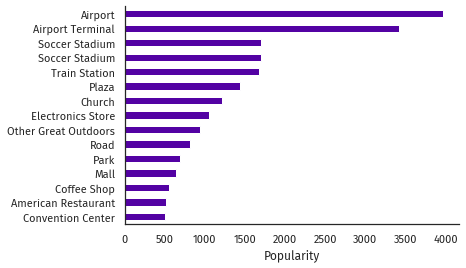

In [79]:
ax = top_popular[['category', 'popularity']].set_index('category').popularity.sort_values(ascending=True).plot(kind='barh', legend=False)
sns.despine(ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Popularity')

Text(0.5, 1, 'Popularity of Cells in the Barcelona Metropolitan Area (Foursquare data)')

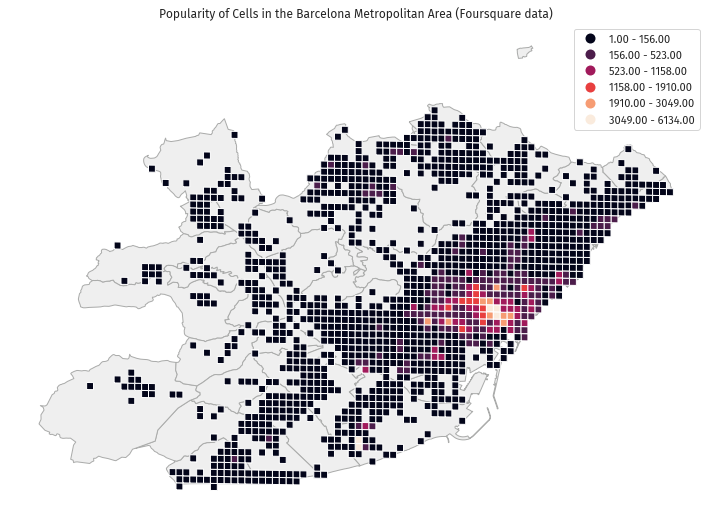

In [81]:
ax = areas.plot(figsize=(18, 9), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
grid.join(venues.groupby('index_right')['popularity'].sum()).dropna().plot(column='popularity', k=6, scheme='Fisher_Jenks', ax=ax, legend=True)
ax.set_axis_off()
ax.set_title('Popularity of Cells in the Barcelona Metropolitan Area (Foursquare data)')

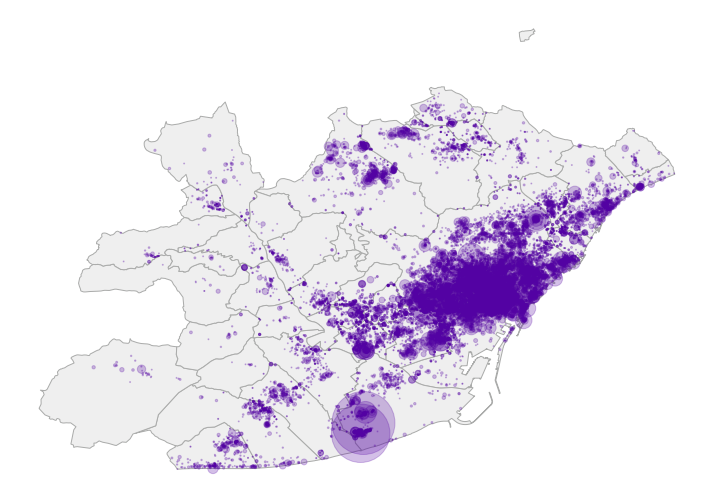

In [82]:
ax = areas.plot(figsize=(18, 9), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
venues.plot(ax=ax, alpha=0.25, markersize='popularity')
ax.set_axis_off()

In [83]:
amb_check_ins.to_csv('output/relevant_check_ins.csv.gz')

In [84]:
pois_grid.to_file('output/relevant_pois.json', driver='GeoJSON')